# Agent Based Modelling

Creates a model for tree death as a result of beetle kill infestations and moisture. 

In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [2]:
# Create Beetle Kill Model 

class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Alive", "Infested", or "Dead"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Alive"
        
    def step(self):
        '''
        If the tree is infested, spread it to alive trees nearby.
        '''
        if self.condition == "Infested":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Alive":
                    neighbor.condition = "Infested"
            self.condition = "Dead"
            
# Want to add in other factors that impact tree death - Tree is more susceptible to death if it is dry 
## Tree Cell can be wet, dry or average.

class TreeMoisture(Agent):
    '''
    Moisture of Tree.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Wet","Dry"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create moisture in cell.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Wet"
        
    def step(self):
        '''
        If the tree is dry, spread it to wet trees nearby.
        '''
        if self.condition == "Average":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Wet":
                    neighbor.condition = "Average"
            self.condition = "Dry"
      

In [3]:
class BeetleKill(Model):
    '''
    Simple Beetle Kill model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Alive": lambda m: self.count_type(m, "Alive"),
                                "Infested": lambda m: self.count_type(m, "Infested"),
                                "Dead": lambda m: self.count_type(m, "Dead")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column Infested.
                    if x == 0:
                        new_tree.condition = "Infested"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more beetle infestation 
        if self.count_type(self, "Infested") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

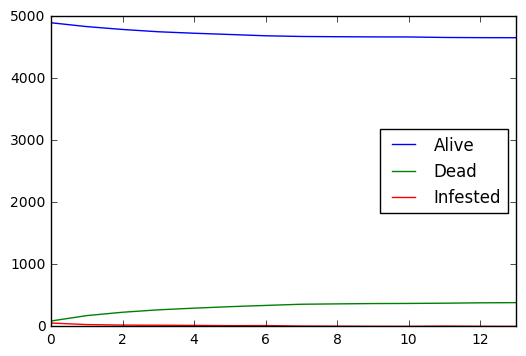

In [4]:
# Test a medium range tree density - 50%
beetle = BeetleKill(100, 100, 0.5)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

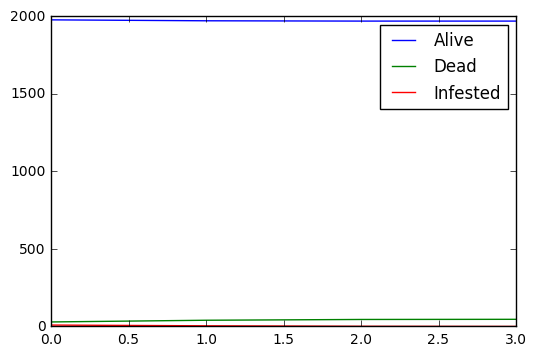

In [5]:
# Test the impact of more sparse tree density - 20% tree cover
beetle = BeetleKill(100, 100, 0.2)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

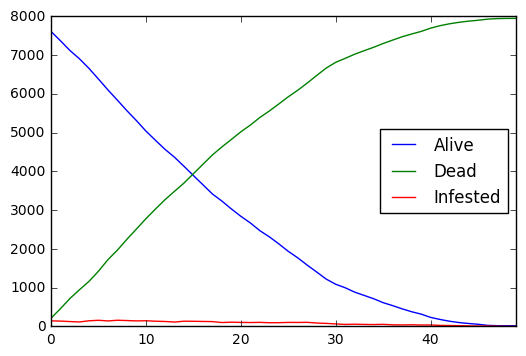

In [6]:
# Test the impact of higher tree density - 80% tree cover
beetle = BeetleKill(100, 100, 0.8)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

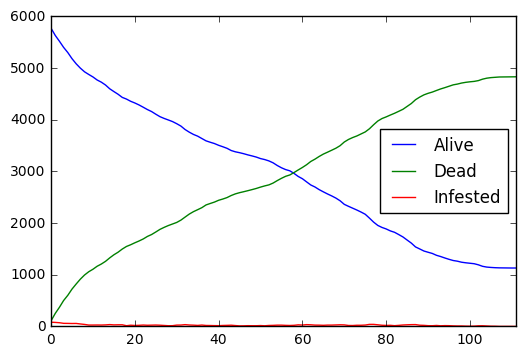

In [7]:
# Test the impact of slightly above half tree density - 60% tree cover
beetle = BeetleKill(100, 100, 0.6)
beetle.run_model()
results = beetle.dc.get_model_vars_dataframe()
results.plot()

In [8]:
param_set = dict(height=50, # Height and width are constant
                 width=50,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])    

In [9]:
# At the end of each model run, calculate the fraction of trees which are Dead
model_reporter = {"Dead": lambda m: (BeetleKill.count_type(m, "Dead") / 
                                          m.schedule.get_agent_count()) }

In [10]:

# Create the batch runner
param_run = BatchRunner(BeetleKill, param_set, model_reporters=model_reporter)

In [11]:
param_run.run_all()

100%|██████████| 100/100 [00:07<00:00,  6.94it/s]


In [12]:

df = param_run.get_model_vars_dataframe()

In [13]:
df.head()


,Dead,Run,density,height,width
0,0.888958,63,0.64,50,50
1,1.000000,86,0.87,50,50
2,0.475867,58,0.59,50,50
3,0.999506,81,0.82,50,50
4,0.080503,30,0.31,50,50


(0, 1)

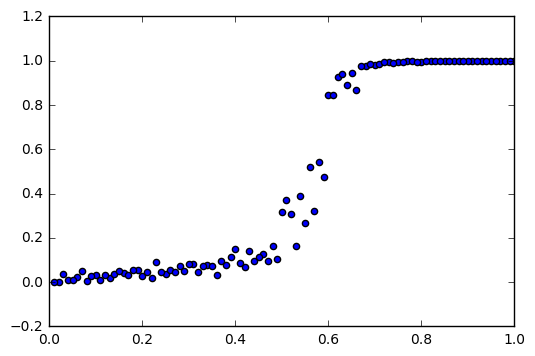

In [14]:
plt.scatter(df.density, df.Dead)
plt.xlim(0,1)

100%|██████████| 500/500 [00:39<00:00,  6.59it/s]


(0, 1)

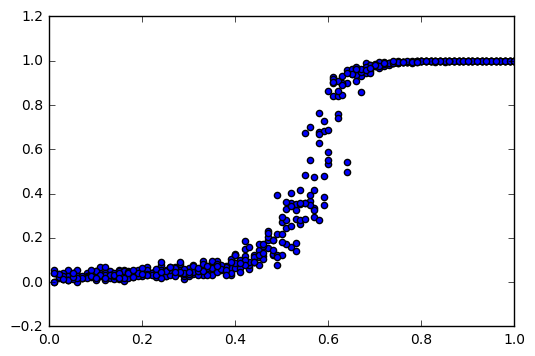

In [15]:
param_run = BatchRunner(BeetleKill, param_set, iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.Dead)
plt.xlim(0,1)

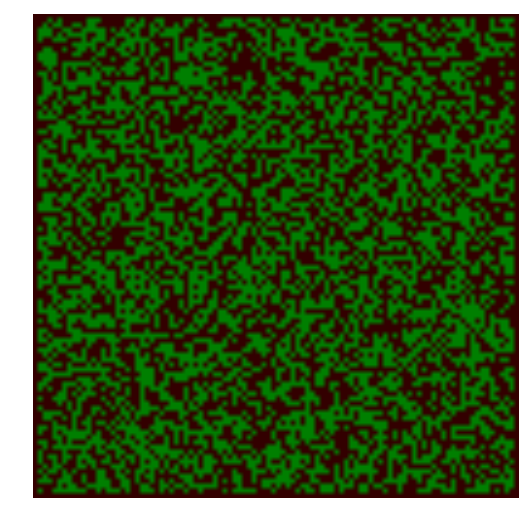

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc, animation
rc('animation', html='html5')

# Displacements from a cell to its eight nearest neighbours
neighbourhood = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
Dead, Alive, Infested = 0, 1, 2
# Colours for visualization: brown for EMPTY, dark green for TREE and orange
# for FIRE. Note that for the colormap to work, this list and the bounds list
# must be one larger than the number of different values in the array.
colors_list = [(0.2,0,0), (0,0.5,0), (1,0,0), 'red']
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

def iterate(beetle):
    """Iterate the forest according to the beetle kill rules."""

    # The boundary of the forest is always empty, so only consider cells
    # indexed from 1 to nx-2, 1 to ny-2
    X1 = np.zeros((ny, nx))
    for ix in range(1,nx-1):
        for iy in range(1,ny-1):
            if X[iy,ix] == Dead and np.random.random() <= p:
                X1[iy,ix] = Alive
            if X[iy,ix] == Alive:
                X1[iy,ix] = Alive
                for dx,dy in neighbourhood:
                    if X[iy+dy,ix+dx] == Infested:
                        X1[iy,ix] = Infested
                        break
                else:
                    if np.random.random() <= f:
                        X1[iy,ix] = Infested
    return X1

# The initial fraction of the forest occupied by trees.
forest_fraction = 0.5
# Probability of new tree growth per empty cell, and of beetle kill.
p, f = 0.05, 0.001
# Forest size (number of cells in x and y directions).
nx, ny = 100, 100
# Initialize the forest grid.
X  = np.zeros((ny, nx))
X[1:ny-1, 1:nx-1] = np.random.randint(0, 2, size=(ny-2, nx-2))
X[1:ny-1, 1:nx-1] = np.random.random(size=(ny-2, nx-2)) < forest_fraction

fig = plt.figure(figsize=(25/3, 6.25))
ax = fig.add_subplot(111)
ax.set_axis_off()
im = ax.imshow(X, cmap=cmap, norm=norm)#, interpolation='nearest')

# The animation function: called to produce a frame for each generation.
def animate(i):
    im.set_data(animate.X)
    animate.X = iterate(animate.X)
# Bind our grid to the identifier X in the animate function's namespace.
animate.X = X

# Interval between frames (ms).
interval = 100
anim = animation.FuncAnimation(fig, animate, interval=interval)
plt.show()

In [19]:
anim.save("test.mp4")

In [31]:
from IPython.display import HTML
HTML(test.mp4.to_html5_video())

NameError: name 'test' is not defined